# Data Visualisation

## Objectives

Providing the client the required visual aid to understand the differences in images for the different labels: Normal, CNV, DME, DRUNSEN, which represent different conditions. This will satisfy bussiness requirement 1.

## Inputs

The notebook requires images divided in the following folders:

1. inputs/OCTdata/train
2. inputs/OCTdata/val
3. inputs/OCTdata/test

## Outputs

1. Image shape embeddings pickle file.
2. Mean and variability of images per label plot.
3. Plot to distinguish the contrast between parasite-contained and uninfected cell images.
4. Generate code that answers business requirement 1 and can be used to build an image montage on the Streamlit dashboard.

---

## Set Directory

### Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from matplotlib.image import imread

Finding the curent working directory

In [2]:
working_dir = os.getcwd()
working_dir

'/workspace/OCTreader/jupiter_notebooks'

Moving it to the workspace directory

In [3]:
os.chdir('/workspace/OCTreader')
working_dir = os.getcwd()
working_dir

'/workspace/OCTreader'

Now we define paths for the train, val, test folders

In [4]:
split_dirs = os.listdir('inputs/OCTdata')
split_paths = {
    split_dirs[0]: 'inputs/OCTdata/' + split_dirs[0],
    split_dirs[1]: 'inputs/OCTdata/' + split_dirs[1],
    split_dirs[2]: 'inputs/OCTdata/' + split_dirs[2]
}
labels = os.listdir(split_paths[split_dirs[0]])

### Set output directory

In [5]:
if os.path.isdir('outputs'):
    versions = os.listdir('outputs')
    os.makedirs(f'outputs/v{len(versions)}')
    output_path = f'outputs/v{len(versions)}'
else:
    os.makedirs('outputs/v1')
    output_path = 'outputs/v1'

## Data visualisation of images

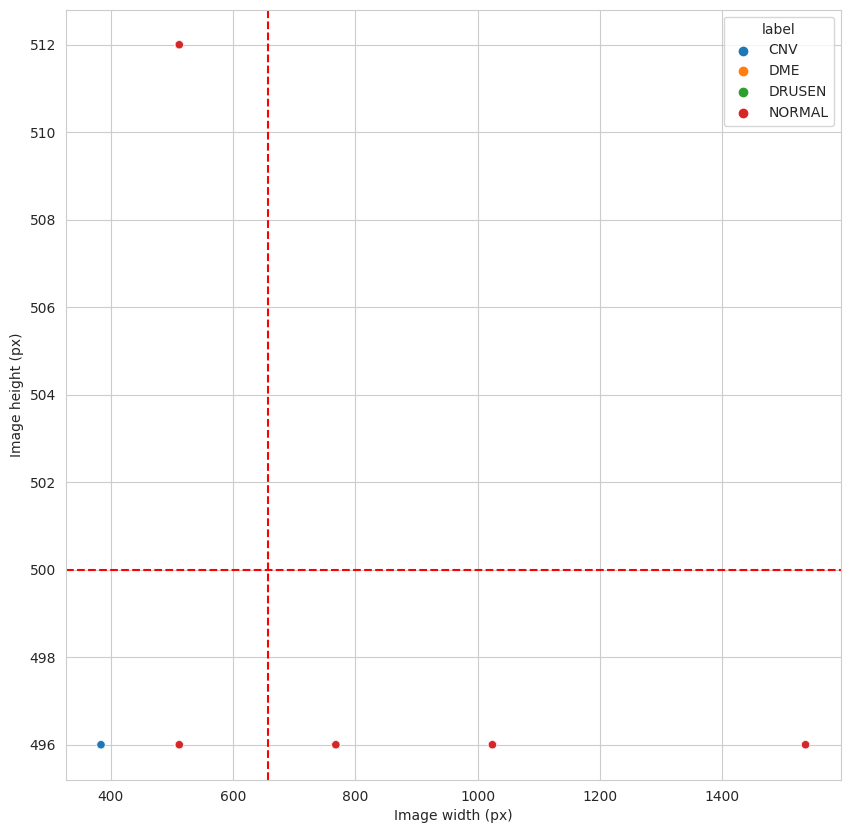

In [6]:
def average_image_shape():
    '''
    Function stores the image shape in df
    calculates mean shape size
    '''
    df = pd.DataFrame(columns=['dim1', 'dim2', 'label'])
    for label in labels:
        label_path = split_paths['train'] + '/' + label
        for image_name in os.listdir(label_path):
            img = imread(label_path + '/' + image_name)
            dim1, dim2 = img.shape
            new_row = {'dim1': dim1, 'dim2': dim2, 'label': label}
            df = df.append(new_row, ignore_index=True)
    means = (df[['dim1', 'dim2']].mean().values.tolist())
    
    sns.set_style('whitegrid')
    fig, axes = plt.subplots(figsize=(10, 10))
    sns.scatterplot(data=df, x='dim2', y='dim1', hue='label')
    axes.set_xlabel('Image width (px)')
    axes.set_ylabel('Image height (px)')
    axes.axvline(x=int(means[1]), color='r', linestyle='--')
    axes.axhline(y=int(means[0]), color='r', linestyle='--')
    plt.show()
    return [int(means[0]), int(means[1])], df



img_avg_size, df_image_shape = average_image_shape()

In [7]:
img_avg_size.append(3)

joblib.dump(value=img_avg_size,
            filename=f"{output_path}/image_shape.pkl")


['outputs/v1/image_shape.pkl']

## Average and stadard deviation of data per label

We start by creating an array for images

In [8]:
from tensorflow.keras.preprocessing import image
import random
def create_image_tensor(data_dir, new_height, new_width, n_images):
    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    new_image_size = (new_height, new_width)
    for label in labels:
        label_path = f'{data_dir}/{label}'
        label_images = os.listdir(label_path)
        random.shuffle(label_images)
        for i in range(n_images):
            img = image.load_img(f'{label_path}/{label_images[i]}', target_size=new_image_size)
            img_array = image.img_to_array(img)
            if img_array.max()>1:
                resized_img = img_array / 255
            else:
                resized_img = img_array
            
            X = np.append(X, resized_img).reshape(-1, new_image_size[0], new_image_size[1], 3)
            y = np.append(y, label)

    return X, y


X, y = create_image_tensor(split_paths['train'], img_avg_size[0], img_avg_size[1], 50)
print(X.shape, y.shape)

(200, 500, 657, 3) (200,)


### Plot and save average and standard deviation of images per label

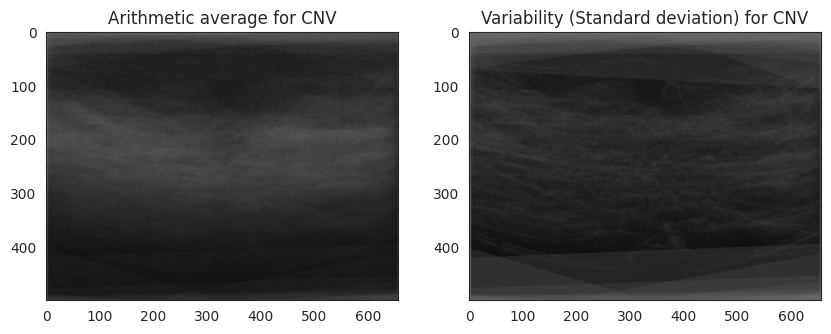

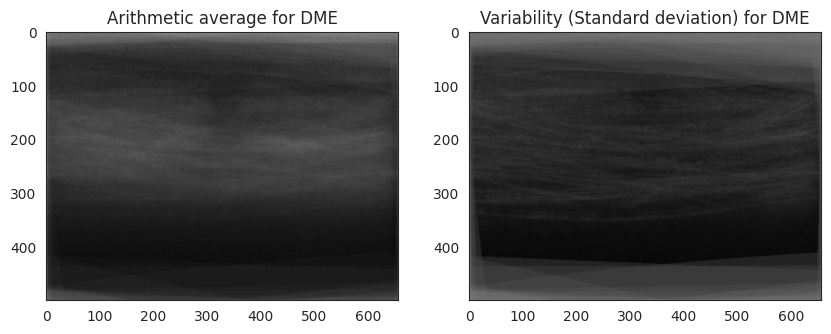

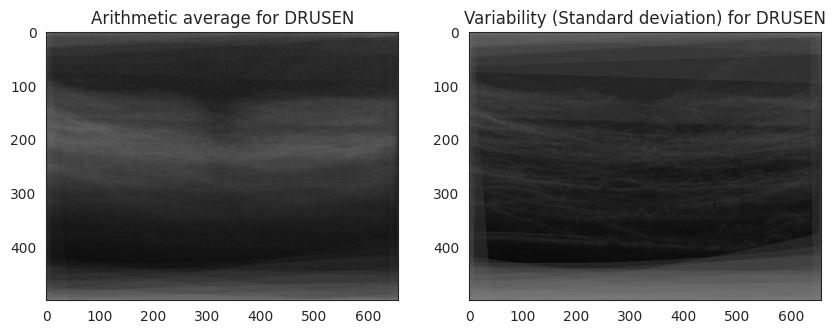

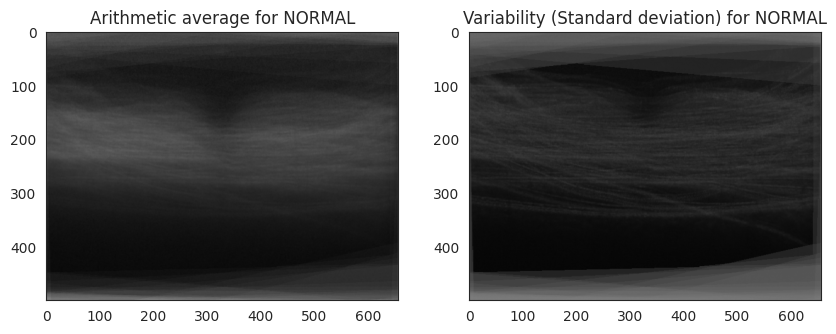

In [9]:

def plot_mean_deviation_per_label(save_image=True):
    sns.set_style("white")
    for label in labels:
        X_label = X[y == label]
        img_mean = np.mean(X_label, axis=0)
        img_std = np.std(X_label, axis=0)
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 15))
        axes[0].set_title(f'Arithmetic average for {label}')
        axes[0].imshow(img_mean)
        axes[1].set_title(f'Variability (Standard deviation) for {label}')
        axes[1].imshow(img_std)
        if save_image:
            plt.savefig(f'{output_path}/{label}_mean_std.png',
                    bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()


plot_mean_deviation_per_label(True)

## Differences among labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


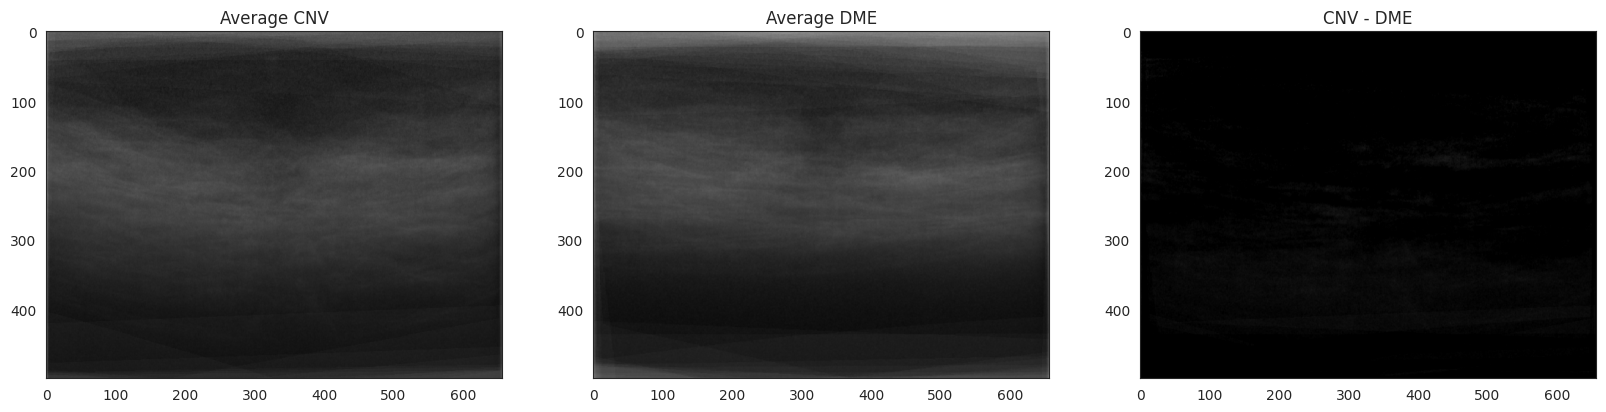

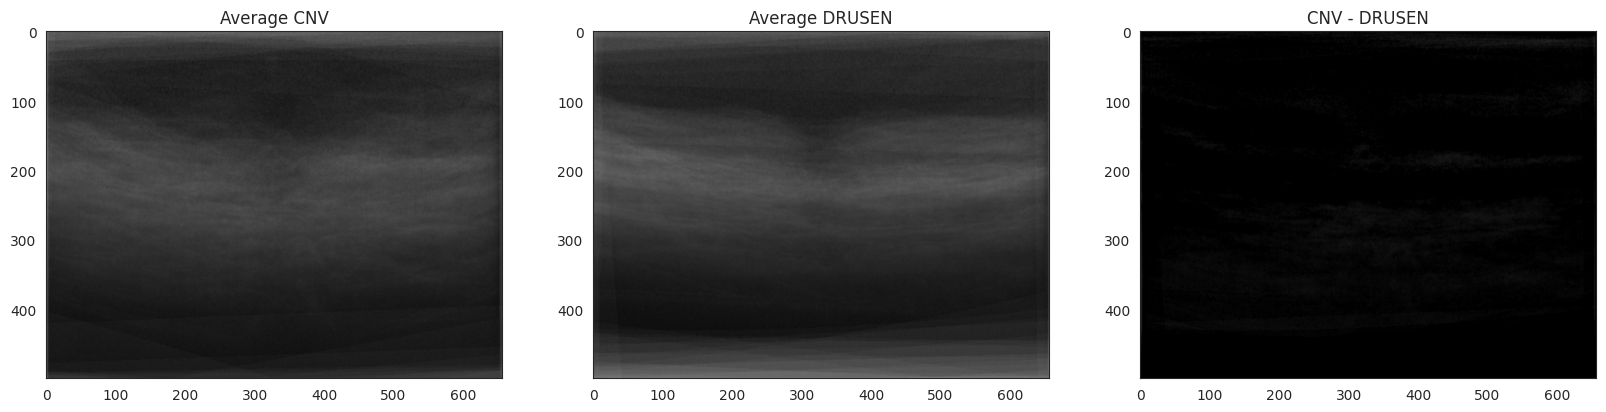

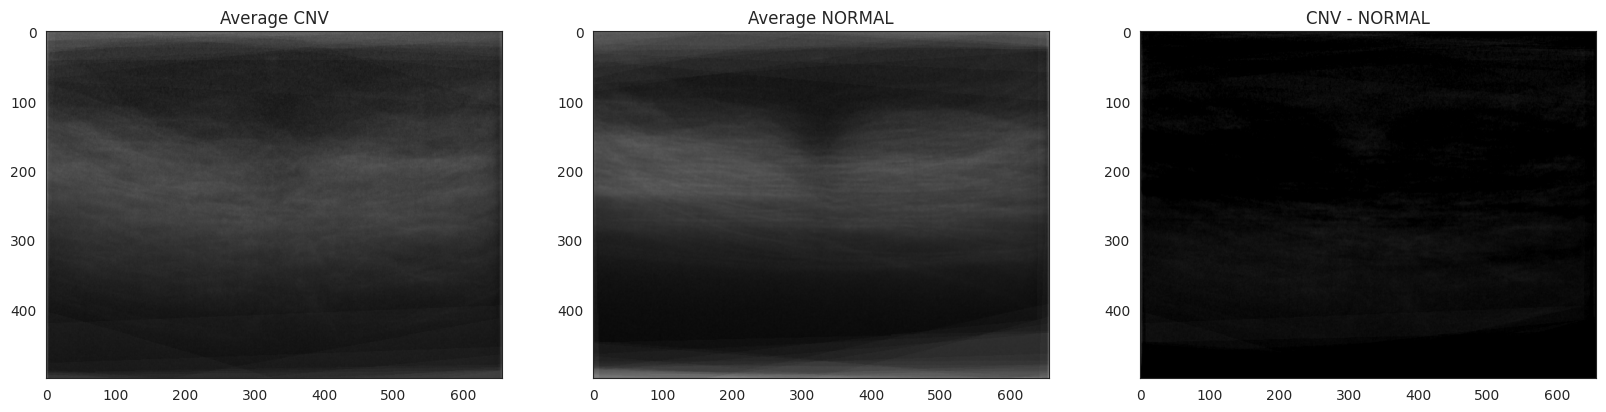

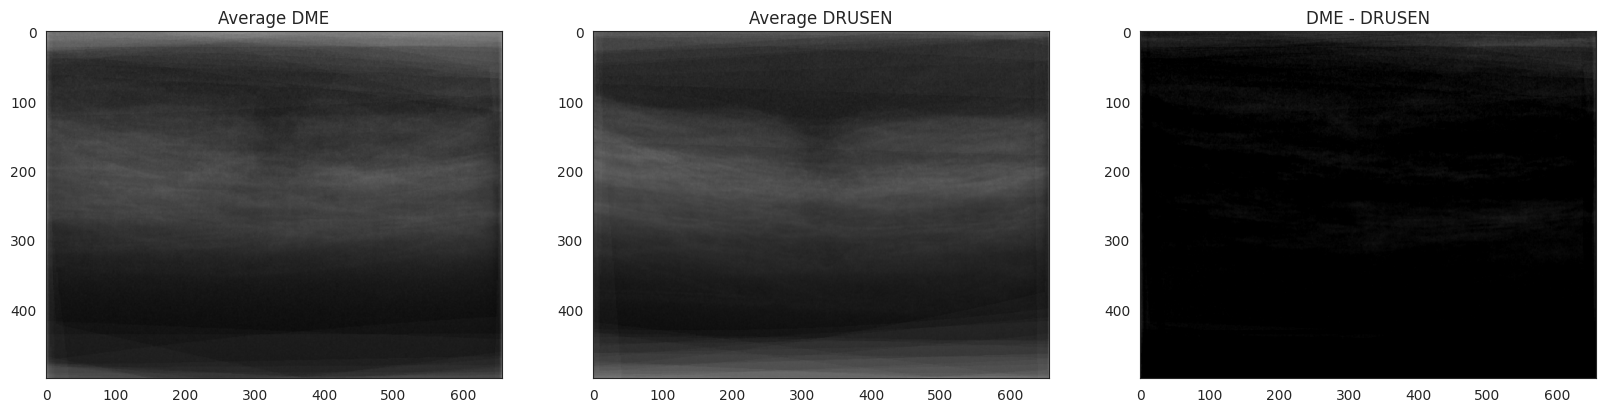

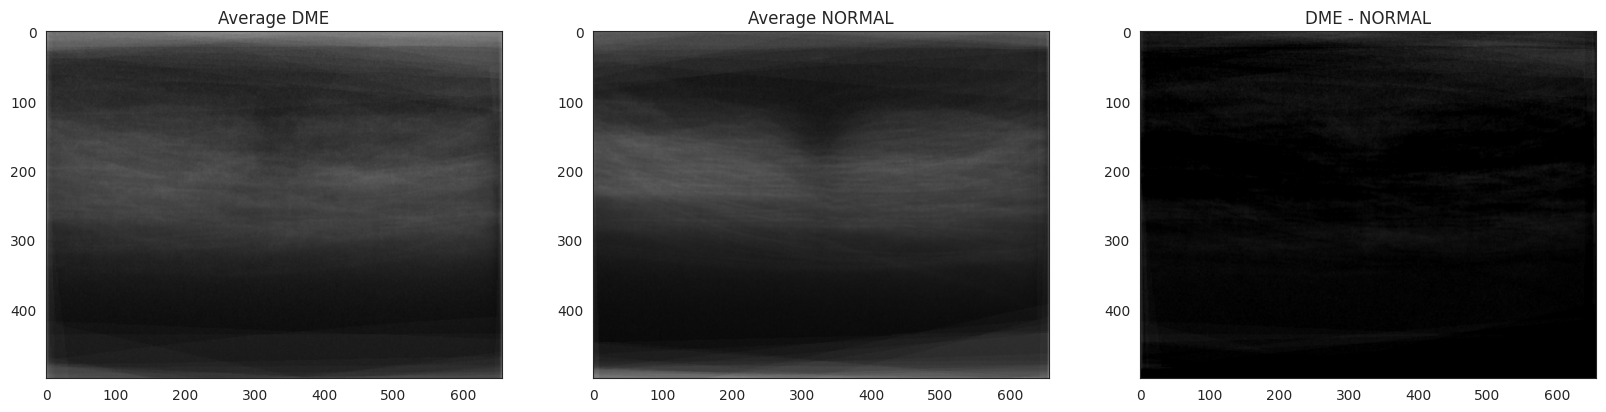

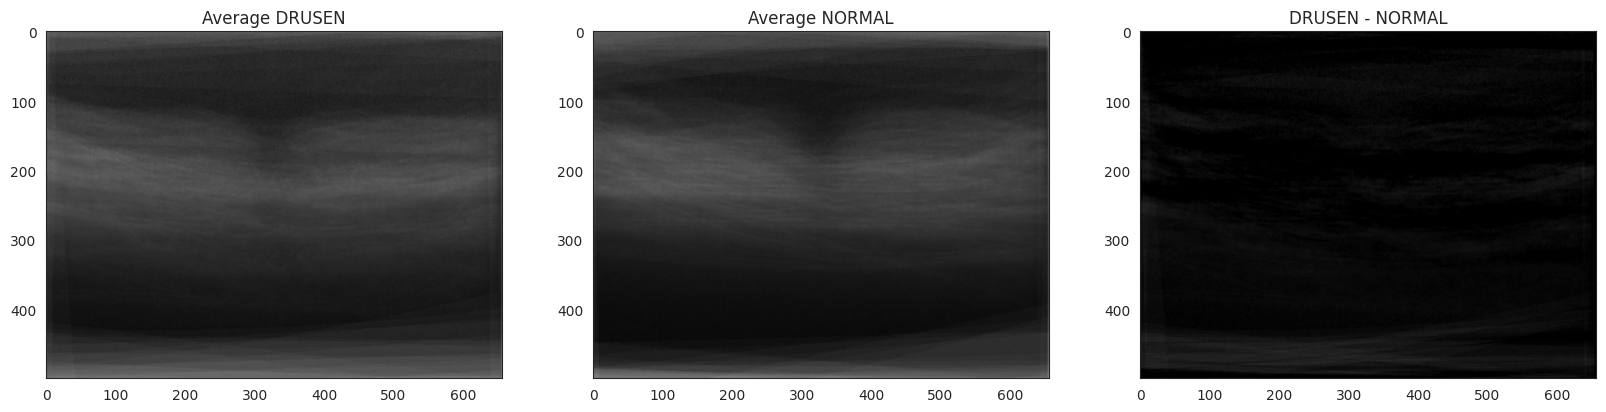

In [10]:
def display_differences_between_labels(img_height, img_width, save_image=False):
    label_average = {}
    for label in labels:
        X_label = X[y==label]
        label_average[label] = np.mean(X_label, axis=0)

    for i in range(len(labels)-1):
        for j in range(i+1, len(labels)):
            image_diff = label_average[labels[i]] - label_average[labels[j]]
            fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(img_height, img_width))
            axes[0].set_title(f'Average {labels[i]}')
            axes[0].imshow(label_average[labels[i]], cmap='gray')
            axes[1].set_title(f'Average {labels[j]}')
            axes[1].imshow(label_average[labels[j]], cmap='gray')
            axes[2].set_title(f"{labels[i]} - {labels[j]}")
            axes[2].imshow(image_diff, cmap='gray')
            if save_image:
                plt.savefig(f'{output_path}/{labels[i]}_{labels[j]}_diff.png',
                    bbox_inches='tight', dpi=150)
            else:
                plt.tight_layout()
                plt.show()


display_differences_between_labels(20, 40, True)

### Image collage

CNV Images


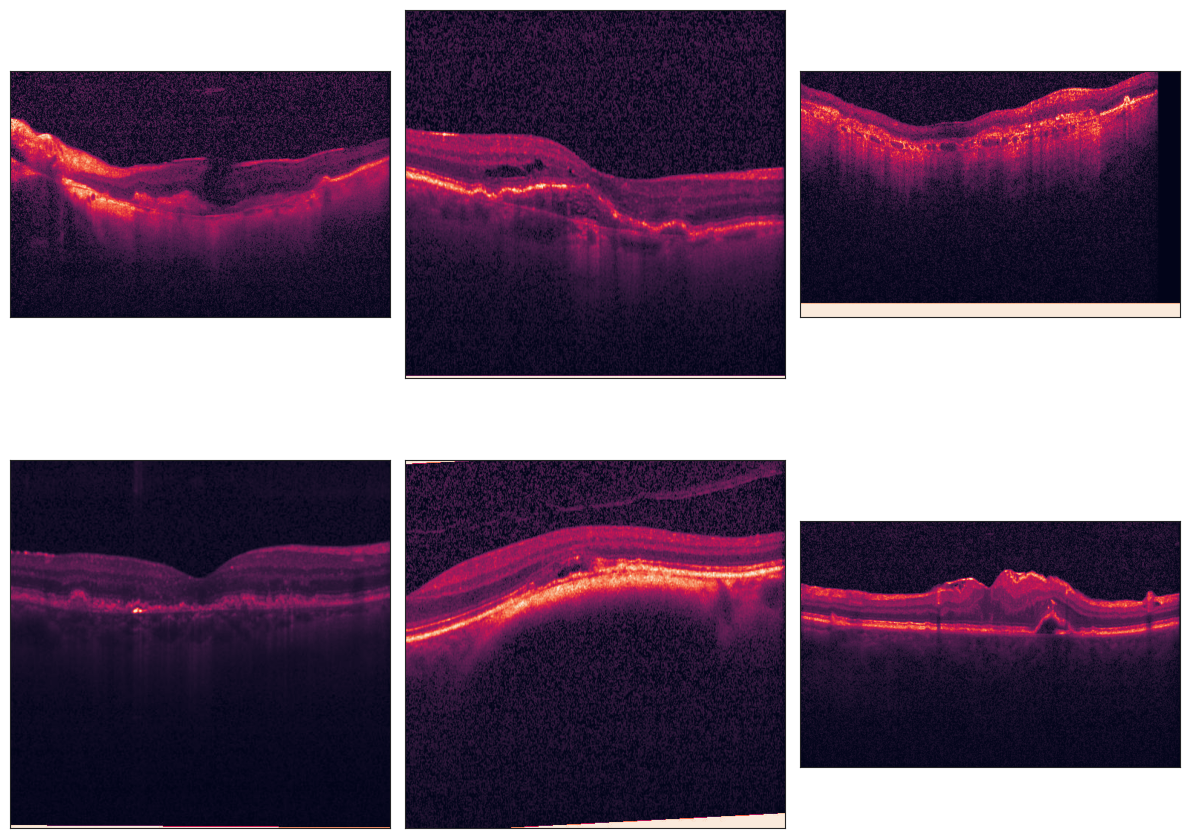

DME Images


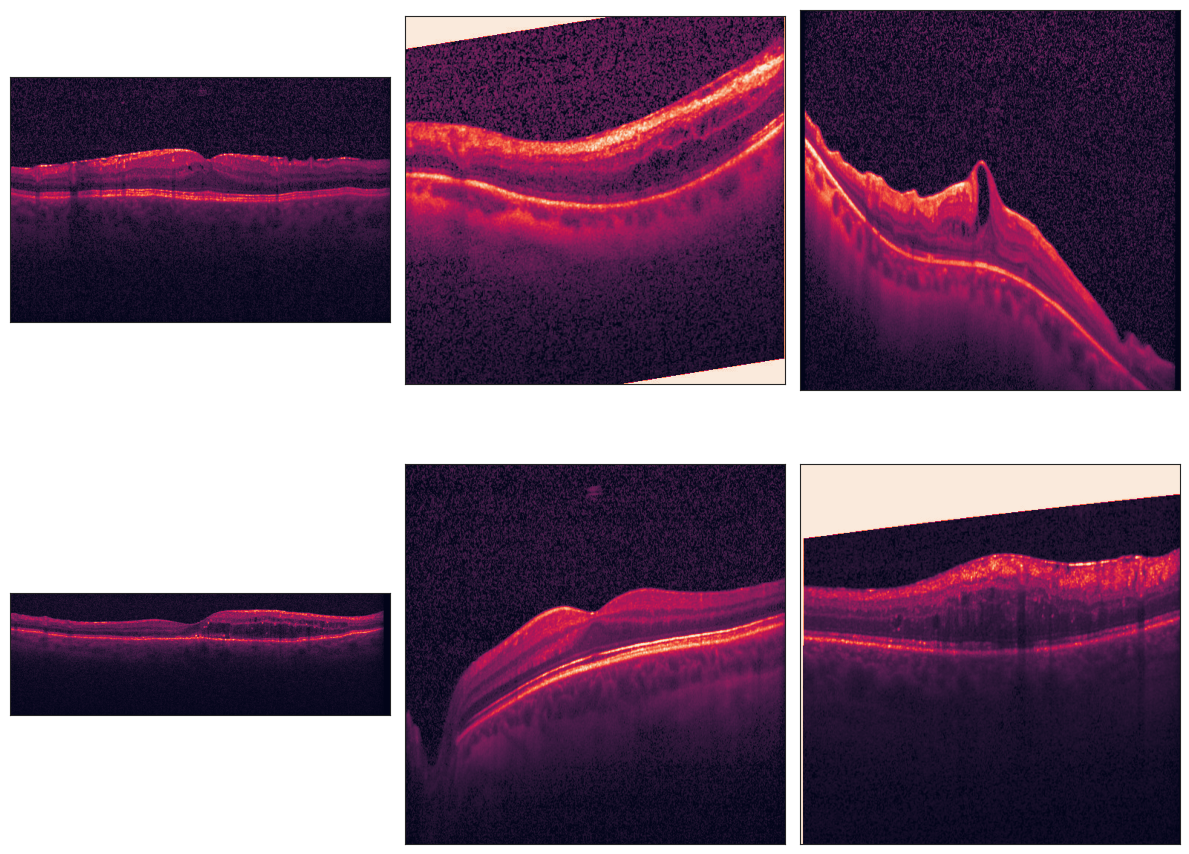

DRUSEN Images


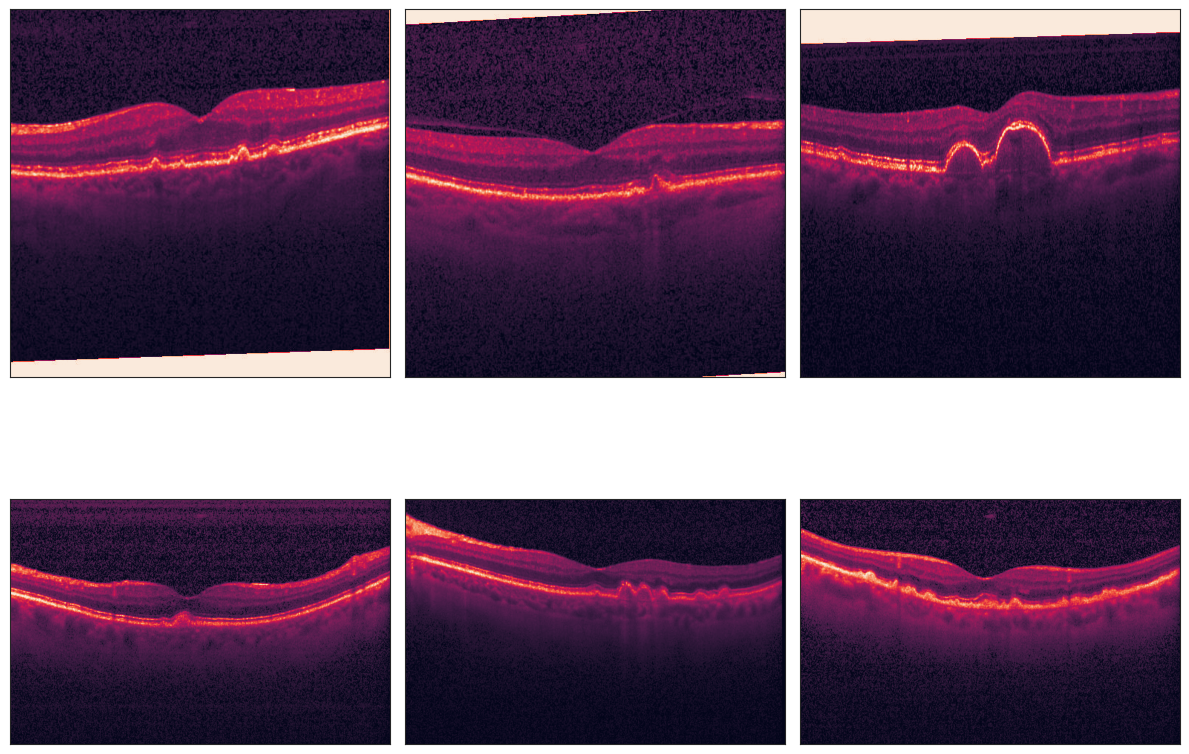

NORMAL Images


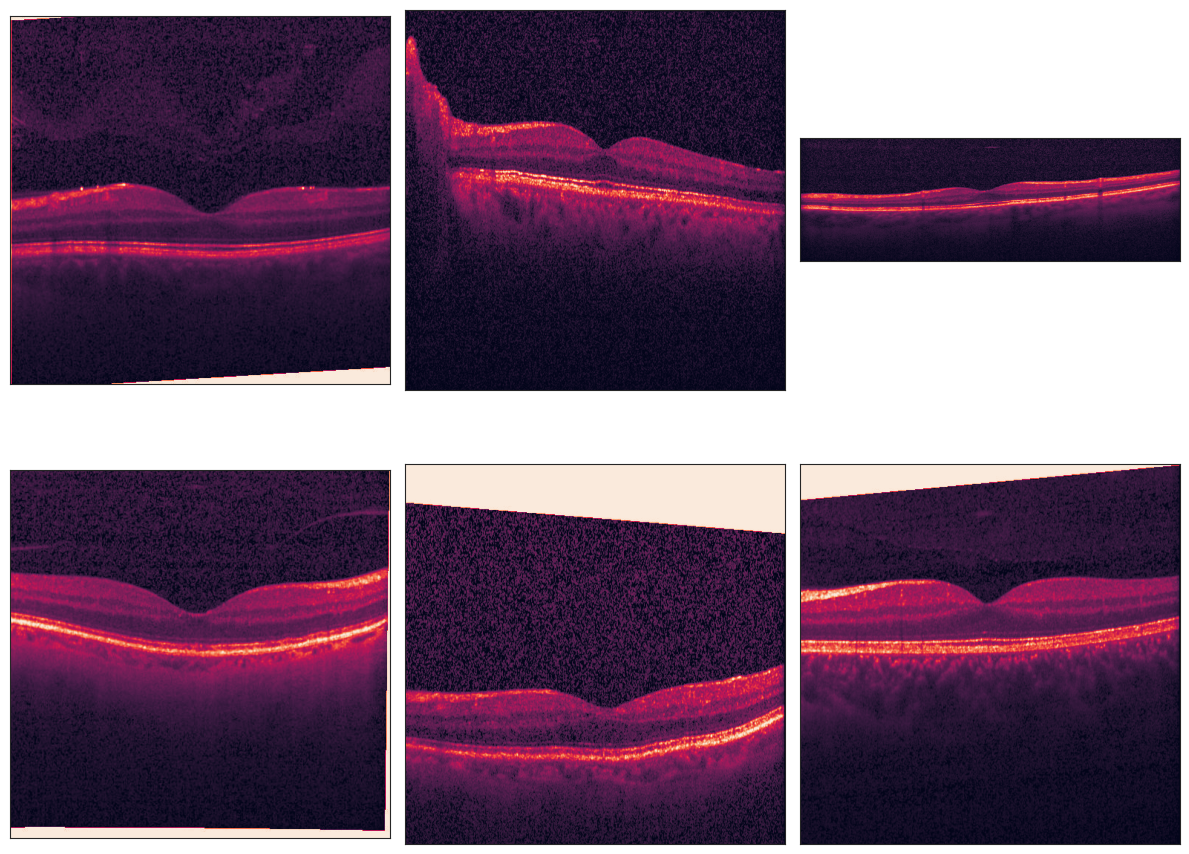

In [11]:
import itertools
def image_collage_per_label(label, nrows, ncols, img_height, img_width):
    '''
    Function creates a collage of images from the train folder
    using for a specific label
    '''
    print(f'{label} Images')
    n_images = nrows * ncols
    images_label = os.listdir(split_paths['train']+ '/' + label)
    random.shuffle(images_label)
    images_list = images_label[0: n_images]
    position_list = list(itertools.product(range(nrows), range(ncols)))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(img_height, img_width))
    count = 0
    for image_name in images_list:
        img = imread(split_paths['train']+ '/' + label + '/' + image_name)
        axes[position_list[count][0], position_list[count][1]].imshow(img)
        axes[position_list[count][0], position_list[count][1]].set_xticks([])
        axes[position_list[count][0], position_list[count][1]].set_yticks([])
        count += 1
    
    plt.tight_layout()
    plt.show()

for label in labels:
    image_collage_per_label(label, 2, 3, 12,10)